# Label Generation

This notebook covers the generation of three different categories.
1. **Sentiment:** Labels to indicate the tone of each response (eg. positive, neutral, negative)
2. **Conversation Stage:** The phase of the conversation (eg. introduction, info gathering, product discussion, etc.)
3. **Response Type:** The nature of the specific response (eg. question, affirmation, objection, etc.)

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import re
import seaborn as sns

In [2]:
# Load the reshaped data (from EDA.ipynb)
df = pd.read_csv("../data/processed/sequential_convos.csv")
df.head()

,conversation_id,turn,speaker,text
0,0,0,Customer,"Hi, Im interested in purchasing a new smartph..."
1,1,0,Customer,"Hi, Im interested in learning more about your..."
2,2,0,Customer,"Hi, Im interested in investing in the stock m..."
3,3,0,Customer,"Hello, Im interested in your financial planni..."
4,4,0,Customer,"Hi, Im interested in purchasing a new laptop...."


___

## Sentiment Labels
* **Purpose:** To capture the tone of each response and provide context to the mood and engagement level of the conversation.
* **Labels:**
  * **Positive:** Speaker expresses agreement or enthusiasm.
  * **Neutral:** Neither positive nor negative (e.g., factual questions or responses).
  * **Negative:** Speaker expresses doubt, confusion, or dissatisfaction.
* **How it is generated:** NLTK’s VADER sentiment analyzer will be utilized as it is commonly used for conversational text. The goal is to aid in understanding the tone of each response and speaker type.

In [3]:
# Load NLTK's VADER sentiment analyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each snippet
df["sentiment_score"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Classify sentiment based on score range: Positive if score > 0.05, neutral if between -0.05 and 0.05, negative if < -0.05
df["sentiment_label"] = df["sentiment_score"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral"))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquelinehong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df.head()

,conversation_id,turn,speaker,text,sentiment_score,sentiment_label
0,0,0,Customer,"Hi, Im interested in purchasing a new smartph...",0.8625,positive
1,1,0,Customer,"Hi, Im interested in learning more about your...",0.4019,positive
2,2,0,Customer,"Hi, Im interested in investing in the stock m...",0.6597,positive
3,3,0,Customer,"Hello, Im interested in your financial planni...",0.4019,positive
4,4,0,Customer,"Hi, Im interested in purchasing a new laptop....",0.6597,positive


___

### Conversation Stage Labels
* **Purpose:** To indicate the general phase or purpose of each snippet in the conversation, aiming to identify a structured flow of the interaction.
* **Labels:**
    * **Introduction:** An early stage where one speaker is greeting the other or starting the conversation.
    * **Information Gathering:** The Salesman asks questions to understand the Customer’s needs. It can also include the Customer asking questions, or the Customer provides responses or background information in reply to those questions.
    * **Product Discussion:** Discussion specifically about product features, specifications, or recommendations.
    * **Objection Handling:** The Salesman addresses any objections brought by the Customer.
    * **Closing/Call to Action:** Salesman suggests a demo, purchase, or their next steps.
    * **Other:** A category for snippets that do not fit in the other classes.
* **How it is Generated:** Rule-based labeling is used with keywords. Conversation Stages are assigned based on matched keywords or phrases found in the conversation (eg. if they're asking about the Customer's needs, it will be labeled as "Information Gathering").
    * The label generation goes through iterative refinement. The process is not entirely shown in this notebook due to its lengthy output, but all of the code is present.
    * The function to label conversation_stage continuously gets words or phrases added according to what is found from manually reading example texts of each classification, with a deeper focus on the "Other" class, which covered nearly half of the dataset in its first iteration.
    * The ordering of the elif statements is based on a typical conversation flow (eg. Intro --> Info Gathering --> Product Discussion --> Objection Handling --> Closing/Call to Action). This is to ensure that keywords related to early stages don't override keywords meant for later stages. By placing Introduction first, we can catch common intro phrases immediately, so they won't mistakenly fall into Information Gathering or another category.

In [5]:
def label_conversation_stage(text):
    text_lower = text.lower()

    # Introduction keywords/phrases
    if any(word in text_lower for word in ["hello", "hi", "good morning", "how can i help", "interested in", "looking for"]):
        return "Introduction"

    # Information Gathering
    elif "?" in text_lower or any(word in text_lower for word in ["tell me", "preferences", "considering", "can you",
                                                                  "could you", "do you", "how can"]):
        return "Information Gathering"
 
    # Product Discussion
    elif any(word in text_lower for word in ["product", "feature", "offer", "recommend", "suits your needs", "compare",
                                             "specifications", "options", "features", "benefits", "includes", "comes with",
                                             "designed for", "suitable for"]):
        return "Product Discussion"
 
    # Objection Handling
    elif any(word in text_lower for word in ["not sure", "concern", "worry", "don’t understand", "too expensive", "issue",
                                             "too costly", "outside my budget", "not confident", "hesitant", "another option",
                                             "problem", "show me", "prove", "evidence", "track record", "risky", "doubtful"]):
        return "Objection Handling"

    # Closing/Call to Action
    elif any(word in text_lower for word in ["demo", "schedule", "sign up", "purchase", "finalize", "next steps", "act now",
                                             "limited offer", "special offer", "commit", "ready to move forward", "register",
                                             "book a time", "place an order", "confirm"]):
        return "Closing/Call to Action"

    # Entries that don’t match any stage
    else:
        return "Other"

In [6]:
# Apply the labeling to the text column
df['conversation_stage'] = df['text'].apply(label_conversation_stage)

In [7]:
# To read a few examples for each stage
for stage in df['conversation_stage'].unique():
    print(f"\nStage: {stage}")
    print(df[df['conversation_stage'] == stage][['speaker', 'text']].head())


Stage: Introduction
    speaker                                               text
0  Customer   Hi, Im interested in purchasing a new smartph...
1  Customer   Hi, Im interested in learning more about your...
2  Customer   Hi, Im interested in investing in the stock m...
3  Customer   Hello, Im interested in your financial planni...
4  Customer   Hi, Im interested in purchasing a new laptop....

Stage: Information Gathering
      speaker                                               text
42   Customer   Im also concerned about the risk involved. Ho...
288  Customer   What are some effective questioning technique...
290  Customer   Ive been having trouble sleeping lately. Do y...
293  Customer      What are the benefits of your health product?
300  Customer   Tell me about your product and how it can hel...

Stage: Product Discussion
      speaker                                               text
200  Customer   Im really frustrated with the current health ...
204  Customer   Im reall

### Conversation Stage Distribution

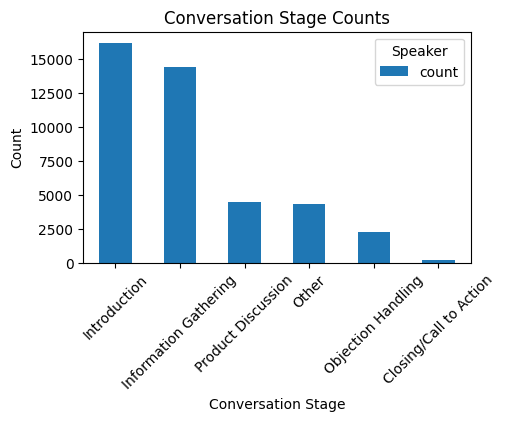

In [8]:
plt.figure(figsize=(5,3))
df['conversation_stage'].value_counts().plot(kind='bar')
plt.title('Conversation Stage Counts')
plt.xlabel('Conversation Stage')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Speaker')
plt.show()

The above distribution seems reasonable, but there are some points to highlight:
1. There are high proportions for Introduction and Information Gathering.
    * This makes sense because Introduction and Information Gathering may be prominent to lay the groundwork for understanding the needs of Customers.
    * This also suggests that the keywords for Introduction might be too general.
2. There is a low count for Closing/Call to Action.
    * This makes sense because not every conversation will lead to a closing action, but I have an assumption that this relates to the possible misclassifications contributing to the high Introduction count. It may also be misclassified as Product Discussion.

To go beyond a personal project, I would go further in identifying better keywords.

### "Other" Exploration
Below is the "Other" exploration I did in order to reduce its count to achieve the amount shown in the above distribution. I repeatedly altered the below code to find ways to modify words/phrases in the labeling function.

In [9]:
other = df[df['conversation_stage']=='Other']
other.head(3)

,conversation_id,turn,speaker,text,sentiment_score,sentiment_label,conversation_stage
217,217,0,Customer,"Yes, exactly. Ive had bad experiences in the ...",0.0679,positive,Other
229,229,0,Customer,Ive been having a lot of trouble finding a re...,-0.4019,negative,Other
254,254,0,Customer,I have been experiencing a lot of back pain l...,-0.5106,negative,Other


In [10]:
other['speaker'].value_counts()

speaker
Salesman    2689
Customer    1635
Name: count, dtype: int64

In [11]:
for text in other['text'][:20]:
    print(text+"\n")

 Yes, exactly. Ive had bad experiences in the past, so reliability is important to me.

 Ive been having a lot of trouble finding a reliable health supplement.

 I have been experiencing a lot of back pain lately. Its really affecting my daily activities.

 Ive been experiencing some back pain lately.

 Ive been experiencing a lot of back pain lately.

 The pain is moderate but persistent, and it has been going on for several months.

 I havent thought about it much. I want to maximize my returns but also minimize the risks involved.

 Ive been having trouble sleeping lately.

 Im really struggling with my weight and cant seem to find a solution.

 I have a moderate risk tolerance, and Im looking to invest for the long term, at least 10 years.

 Im willing to take on moderate risk, and I plan to invest for the long term.

 Well, I have some savings, but Im worried about inflation and market fluctuations affecting my retirement funds.

 Ive been experiencing some back pain lately.

 I a

**Most Common Words in "Other" Category**

In [12]:
# Tokenize the text and count word frequencies
all_words = [word.lower() for text in other['text'] for word in re.findall(r'\b\w+\b', text)] # regex to remove punctuation

# Count the most common words
word_counts = Counter(all_words)

# Remove stopwords from word count
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# The top 20 most common words
common_words_other = Counter(filtered_word_counts).most_common(20)
pd.DataFrame(common_words_other, columns=['word', 'frequency'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquelinehong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,frequency
0,im,647
1,understand,628
2,absolutely,591
3,provide,487
4,lets,487
5,communication,482
6,financial,479
7,let,459
8,important,430
9,make,417


**Checking specific words within the above list, modifying the word each time.**

In [13]:
for text in other[other['text'].str.contains("understand", case=False, na=False)]["text"][:20]:
    print(text+"\n")

 Im having trouble understanding some of the sales pitches Ive been hearing.

 Good to hear. I believe that would enhance my understanding and build trust.

 I dont understand why negotiation and conflict resolution skills are important in sales.

 I dont understand why negotiation and conflict resolution skills are important in sales.

 I dont understand why negotiation and conflict resolution skills are important in the health industry.

 Absolutely! Id be happy to assist you. Lets start by building a rapport and understanding your investment goals and needs.

 I completely understand your interest in the stock market. It can be overwhelming for beginners, but Im here to guide you through the process.

 Absolutely. Its important to us that you fully understand our services. Let me break it down for you in simple terms...

 Definitely. We want to ensure that you have a clear understanding of our services and how they can benefit you.

 Thats great to hear! Investing in the stock marke

**End:** After a number of iterations, the "Other" count has decreased to a moderate size. A further reduction could lead to mislabeling and a distortion of the dataset's quality.

___

## Response Type
* **Purpose:** To describe the nature or intent of each response, providing an idea of how speakers react within each stage (eg. question, objection).
* **Labels:**
    * **Question:** An inquiry or request for information, typically a signal of a need for more details. Speaker seeks new info.
    * **Affirmation:** Agreement or confirmation, suggesting the speaker is in favor of the topic.
    * **Disagreement:** Opposition, hesitation, or a negative stance.
    * **Clarification:** Speaker attempts to understand or confirm something that has already been mentioned.
    * **Explanation:** Providing additional information, examples, or details to aid the recipient's understanding.
    * **Objection:** A display of concern, doubt, or issues regarding the topic.
    * **Suggestion/Recommendation:** Advice is offered or an idea is proposed, involving potential solutions.
    * **Acknowledgment:** Indication of understanding or recognition of the previous statement without necessarily agreeing or disagreeing.
    * **Request for Action:** A specific response is asked for from the other speaker, often prompting a next step.
    * **Other:** A category for snippets that do not fit in the other classes.
* **How it is Generated:** Rule-based labeling is used with keywords. Response Types are assigned based on matched keywords or phrases found in the conversation (eg. if they're giving an example, it will be labeled as "Explanation").
    * The label generation goes through iterative refinement. The process is not entirely shown in this notebook due to its lengthy output, but all of the code is present.
    * The function to label response_type continuously gets words or phrases added or modified according to what is found from manually reading example texts of each classification, with a deeper focus on the "Other" class, which covered nearly half of the dataset in its first iteration.
    * The elif statements are ordered to prioritize common, straightforward responses like Question and Affirmation first, since they are often more frequent and clear in conversations. Types that might have overlapping phrases (like Clarification and Explanation) follow after to reduce the chance of mislabeling. The more specific intents are placed last to catch more unique and purposeful responses without overriding the earlier ones (eg. Request for Action).

In [14]:
def label_response_type(text):
    text_lower = text.lower()  # Convert text to lowercase for consistent matching
    if "?" in text_lower or any(word in text_lower for word in ["could you", "can you", "do you", "would you"]):
        return "Question"
    elif any(word in text_lower for word in ["yes", "i agree", "sounds good", "exactly", "of course"]):
        return "Affirmation"
    elif any(word in text_lower for word in ["no", "don't think", "disagree", "not sure", "doesn't work"]):
        return "Disagreement"
    elif any(word in text_lower for word in ["clarify", "explain more", "elaborate", "could you explain", "understand"]):
        return "Clarification"
    elif any(word in text_lower for word in ["let me explain", "to clarify", "this means", "for example", "in other words"]):
        return "Explanation"
    elif any(word in text_lower for word in ["concern", "hesitant", "issue", "problem", "not convinced", "worry", "risk"]):
        return "Objection"
    elif any(word in text_lower for word in ["recommend", "suggest", "consider", "you should", "why not", "how about"]):
        return "Suggestion/Recommendation"
    elif any(word in text_lower for word in ["okay", "i see", "got it", "understand"]):
        return "Acknowledgment"
    elif any(word in text_lower for word in ["schedule", "book", "set up", "send me", "provide", "assist"]):
        return "Request for Action"
    else:
        return "Other"

In [15]:
# Apply the labeling to the text column
df['response_type'] = df['text'].apply(label_response_type)

In [16]:
df['response_type'].nunique()

10

In [17]:
# To read a few examples of each type
for resp_type in df['response_type'].unique():
    print(f"\nType: {resp_type}")
    print(df[df['response_type'] == resp_type][['speaker', 'text']].head())


Type: Question
    speaker                                               text
0  Customer   Hi, Im interested in purchasing a new smartph...
2  Customer   Hi, Im interested in investing in the stock m...
4  Customer   Hi, Im interested in purchasing a new laptop....
6  Customer   Hi, Im interested in purchasing a new laptop....
7  Customer   Im looking for a new healthcare provider. Can...

Type: Other
     speaker                                               text
1   Customer   Hi, Im interested in learning more about your...
3   Customer   Hello, Im interested in your financial planni...
5   Customer   Hi, Im interested in your financial planning ...
8   Customer   Hi, Im interested in your financial planning ...
12  Customer   Hi, Im interested in your financial planning ...

Type: Disagreement
      speaker                                               text
15   Customer   Im interested in purchasing a new laptop, but...
16   Customer   Hi there! Im in the market for a new laptop

### Response Type Distribution

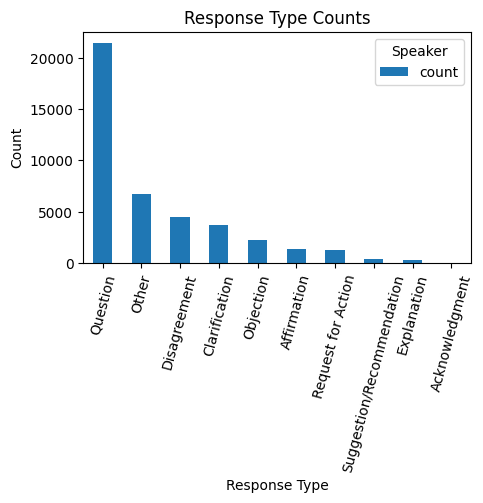

In [18]:
plt.figure(figsize=(5,3))
df['response_type'].value_counts().plot(kind='bar')
plt.title('Response Type Counts')
plt.xlabel('Response Type')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.legend(title='Speaker')
plt.show()

The above distribution seems reasonable. Some areas to note:
1. Question is the most common response type by a large margin. This makes sense in a sales or customer support conversation where Customers often seek additional information. This suggests that information-seeking behavior is dominant in the dataset.
2. The Other response type is the second highest, possibly indicating that the complexity of some responses is beyond the current labels.
3. Disagreement and Clarification are fairly high, which may indicate active dialogue and information-seeking trends.
4. Request for Action is also decently sized, which displays a good amount of direct requests within interactions.

**Response Type by Speaker**

In [19]:
df[['speaker', 'response_type']].value_counts().sort_index(level='response_type')

speaker   response_type            
Customer  Acknowledgment                   2
Salesman  Acknowledgment                  19
Customer  Affirmation                    200
Salesman  Affirmation                   1142
Customer  Clarification                  157
Salesman  Clarification                 3516
Customer  Disagreement                  2263
Salesman  Disagreement                  2248
Customer  Explanation                      7
Salesman  Explanation                    242
Customer  Objection                      746
Salesman  Objection                     1454
Customer  Other                         2808
Salesman  Other                         3903
Customer  Question                     14581
Salesman  Question                      6888
Customer  Request for Action              85
Salesman  Request for Action            1182
Customer  Suggestion/Recommendation       78
Salesman  Suggestion/Recommendation      333
Name: count, dtype: int64

<Figure size 500x300 with 0 Axes>

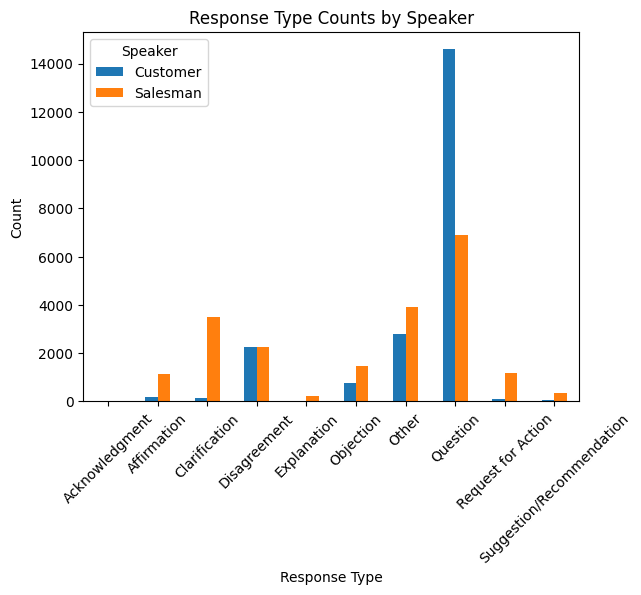

In [20]:
plt.figure(figsize=(5, 3))
df.groupby(['response_type', 'speaker']).size().unstack().plot(kind='bar')
plt.title('Response Type Counts by Speaker')
plt.xlabel('Response Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Speaker')
plt.show()

**Observations:**
* **Questions:** Customers ask a larger portion of the questions. This indicates a customer-driven inquiry focus.
* **Clarification:** Salesmen hold most of this response type, possibly reflecting their role in addressing customer misunderstandings.
* **Disagreement:** It is pretty even. Disagreement from Salesmen may be for countering objections.
* **Affirmation and Acknowledgment:** These types are mostly used by Salesmen, possibly due to them confirming understanding or agreeing with the Customer.
* **Request for Action:** Requests for Action are more common for Salesmen. This aligns with typical sales dynamics.

### "Other" Exploration
Below is the "Other" exploration I did in order to reduce its count to achieve the amount shown in the above distribution. I repeatedly altered the below code to find ways to modify words/phrases in the labeling function.

In [21]:
other = df[df['response_type']=='Other']
other.head(3)

,conversation_id,turn,speaker,text,sentiment_score,sentiment_label,conversation_stage,response_type
1,1,0,Customer,"Hi, Im interested in learning more about your...",0.4019,positive,Introduction,Other
3,3,0,Customer,"Hello, Im interested in your financial planni...",0.4019,positive,Introduction,Other
5,5,0,Customer,"Hi, Im interested in your financial planning ...",0.4019,positive,Introduction,Other


In [22]:
other['speaker'].value_counts()

speaker
Salesman    3903
Customer    2808
Name: count, dtype: int64

In [23]:
for text in other['text'][:20]:
    print(text+"\n")

 Hi, Im interested in learning more about your health products.

 Hello, Im interested in your financial planning services.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in purchasing a new smartphone.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in your health coaching services.

 Hi, Im interested in purchasing a new laptop.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in investing in your financial products.

 Im interested in purchasing a new laptop for my business.

 Hi, Im interested in purchasing a new laptop for my business needs.

 Hi, Im interested in purchasing a new laptop for my graphic design work.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in your financial planning services.

 Hi, Im interested in your health insurance plans.

 Hi,

**Most Common Words in "Other" Category**

In [24]:
# Tokenize the text and count word frequencies
all_words = [word.lower() for text in other['text'] for word in re.findall(r'\b\w+\b', text)] # regex to remove punctuation

# Count the most common words
word_counts = Counter(all_words)

# Remove stopwords from word count
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# The top 20 most common words
common_words_other = Counter(filtered_word_counts).most_common(20)
pd.DataFrame(common_words_other, columns=['word', 'frequency'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquelinehong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,frequency
0,im,1498
1,product,1262
2,absolutely,1113
3,customers,848
4,financial,816
5,let,746
6,health,734
7,help,623
8,testimonials,564
9,lets,545


In [25]:
# for text in other[other['text'].str.contains("customers", case=False, na=False)]["text"][:20]:
#     print(text+"\n")

___

## Limitations
* Potential Misclassifications - Keyword overlap may lead to inaccurate labeling, which would also contribute to a reduction in overall accuracy. With additional resources, a pre-trained model could assist with labeling or manual annotators.
* The "Other" category is broad, potentially masking more specific response types that could be of great use. Reviewing more data samples and refining categories could help break down this section.
* Some responses contain elements that belong to multiple categories, complicating single-label assignment. Multi-label classification could be considered to account for overlapping categories.
* Due to the project's scope and time constraints, keyword exploration for category selection was not as involved as it could be with more time used.
* Labels are assigned without considering prior dialogue. Response types could be more accurate with that context used in the labeling process.
* The sentiment labeling doesn't fully capture the emotional tone, especially without the context of prior dialogue.

## Final Thoughts

This labeling approach provides a practical solution for the goals and scope of this project. Through keyword-based labeling, iterative refinement, and consideration of class balance (especially regarding the originally large "Other" category), I gained a meaningful understanding of the typical conversation flow and response dynamics. The use of diverse labels, including conversation stages and response types, helped capture multiple aspects of dialogue. Even though there are limitations, these methods provide an effective starting point. Overall, this approach meets the project's goals and needs.

In [27]:
# df.to_csv("../data/processed/labeled_sequential_convos.csv", index=False)